# 21M.387 Fundamentals of Music Processing
## Problem Set 5: Beat Detection

Make sure all your answers and plots display when the code block is run. You can leave word-based answers in code comments or markdown cells.

You may use any fmplib functions from __previous__ units in your answers. You may __not__ use any fmplib functions from the current unit in your answers (unless explicitly noted). But you can use the current unit's fmplib for testing your code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from ipywidgets import interact
import sys
sys.path.append("..")
import fmplib as fmp

plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['image.interpolation'] = 'nearest'

fmp.documentation_button()

## Exercise 1

Load the audio below, listen to it, and create $\Delta[n]$, the Spectral Novelty Function, using `fmp.spectral_novelty` and these parameters:

$N = 1024$  
$H = 512$  
$\gamma = 10$

- Name it `nov1`
- Plot it



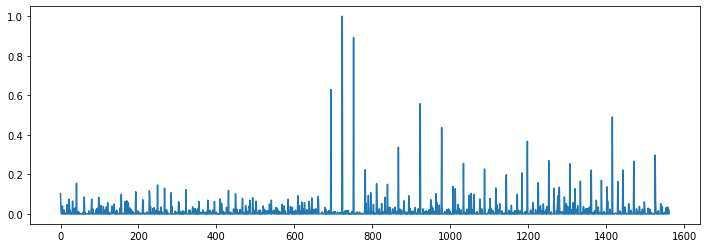

In [3]:
x1 = fmp.load_wav("audio/beatles_lucy_excerpt.wav")
fs = 22050
ipd.display(ipd.Audio(x1, rate=fs))

N = 1024
H = 512
gamma = 10
nov1 = fmp.spectral_novelty(x1, N, H, gamma)
plt.plot(nov1)

Create $\mathcal{F}[n, k]$, the Fourier Tempogram from this novelty curve using the parameters:

$N_{tg} = 256$  
$H_{tg} = 32$  
$Z_{tg} = 16$  

Use `fmp.stft` with the `centered=False` option for the STFT. This will be important later on.

- Name it `tg1`
- Plot the magnitude with `plt.imshow`.

In [ ]:
tg1 = ...

You now have three time series:

- The original audio recording $x[n]$
- The novelty function $\Delta[n]$
- The tempogram $\mathcal{F}[n, k]$

Each has a different sampling rate. It is important to keep these in mind to avoid confusion later on.

1. What are the sampling rates for each of the above signals?
1. For the tempogram $\mathcal{F}[n, k]$, what value of $k$ corresponds to 120 BPM?
1. What tempo (in BPM) does $k=100$ represent in the tempogram?

Please answer these questions by showing your calculations in python and printing the results.

In [ ]:
# calculate sampling rates
f_x = ...
f_delta = ...
f_tg = ...

# k of 120 BPM?
ex1_k = ...

# k=100 corresponds to what BPM?
ex1_bpm = ...

## Exercise 2

Write the function `best_tempogram_bins()` that returns the index ($k$) of the most likely tempo for each column of a Fourier tempogram. However, instead of just returning the column-wise maximum, narrow the answer to fit within a given tempo range.

Inputs:  
- `tg`: the tempogram
- `ff`: $F_f$, the sampling rate of $\Delta[n]$
- `bpm_min`, `bpm_max`: tempo constraints in beats-per-minute

Output:  
- a vector, same length as `tg`, where each value is the index ($k$) of the most likely tempo, subject to the tempo constraints

Strategy:
- Convert the min/max tempos into frequency bins ($k$'s)
- Find the maximum $k$ from only a subregion of the tempogram, as delimited by the min/max $k$'s

In [ ]:
def best_tempogram_bins(tg, ff, bpm_min, bpm_max):
    pass

Now test your function with the spectral novelty you created above using a BPM range of $[30:250]$.

In a single figure:
- plot the tempogram, but only in the subrange $k = [0 - 400]$
- plot the best tempo estimates as red dots [Hint: use `'ro'`]


In [ ]:
# tempogram with best tempo estimate plot


## Exercise 3

Using the best-tempo-estimate bins from above, which represent the most likely tempo values per time slot, find the sinusoid parameters used to recreate the PLP (Predominant Local Pulse). Creating the actual PLP happens in the next exercise.

The function `get_sinusoid_params()` below should return the set of frequencies and phases associated with the given bins of the tempogram.

Inputs:
- `tg`: the tempogram
- `ff`: $F_f$, the sampling rate of $\Delta[n]$
- `bins`: the best-tempo estimates calculated above.

Outputs:
- `(freqs, phases)`, a tuple of vectors representing the frequencies at each bin and the phases at each bin.


In [ ]:
def get_sinusoid_params(tg, ff, bins):
    pass

Calculate the frequencies and phases for the above tempogram using your function and plot them.

In [ ]:
# plot frequencies and phases (on two separate plots) of best tempo estimates.


## Exercise 4

The final step in creating the PLP - aka $\Gamma[n]$ - is to go through each frequency / phase pair, generate a windowed sinusoid, and then add up all these sinusoids together. The trick is to place the generated sinusoid at the proper location in time.

Write the function `make_plp()`

Inputs:
- `freqs`: frequencies from `get_sinusoid_params()` 
- `phases`: phases from `get_sinusoid_params()`
- `ff`: $F_f$, the sampling rate of $\Delta[n]$
- `win_len_tg`: $N_{tg}$, the window length used to create the tempogram from $\Delta[n]$
- `hop_tg`: $H_{tg}$, the hop size used to create the tempogram from $\Delta[n]$


Output:
- the predominant local pulse as an array, sampled at $F_f$.

Strategy:
- Create a cosine of length $N_{tg}$, sampled at $F_f$, for each input frequency/phase.
- Taper this cosine with a Hann window of the same length.
- All these windowed cosines must be shifted by the proper amount and added to $\Gamma[n]$. Hint: you will need to use $H_{tg}$ to help find the proper shift amount.
- As a final step, half-wave-rectify the entire PLP signal before returning it.

In [ ]:
def make_plp(freqs, phases, ff, win_len_tg, hop_tg):
    pass

Now, to see it working:

- Create the PLP
- Plot $\Delta[n]$, the Novelty Function, and $\Gamma[n]$, the PLP, on the same plot.
- Pick all the peaks of $\Gamma[n]$ and use those values to generate clicks so you can hear the results. You can use the helper function `listen_to_clicks` below.

In [ ]:
def listen_to_clicks(click_locations, audio) :
    '''click_locations: the samples at which to generate a click sound.
    audio: the original audio track
    returns Audio with clicks in left and audio in right channels
    '''
    click_snd = fmp.load_wav('audio/click.wav')
    clicks = fmp.make_clicks(click_locations, len(audio), click_snd)
    ipd.display(ipd.Audio((clicks, audio), rate = 22050))

plp = ...

# plot nov1 and PLP

peaks = ...

# listen to peaks

## Exercise 5

In the next three exercises, we will examine beat detection by dynamic programming.

Write the function `beats_score()` which return $\mathbf{S}(B)$, the score for an arbitrary beat sequence $B = (b_1, b_2, b_3, ... b_L)$ and a novelty function $\Delta[n]$.

For the penalty term, use the function from lecture:
$$P_{\hat \delta}(\delta) = -(\log_2(\delta / \hat \delta))^2$$

Inputs:

- `nov`: The novelty function $\Delta[n]$
- `beats`: A beats sequence $B$
- `est_period`: the estimated beat period $\hat \delta$
- `lam`: the balancing factor $\lambda$
    
Output:
- a score value

In [ ]:
def beats_score(nov, beats, est_period, lam):
    pass

Using the parameters $\hat \delta = 4$ and $\lambda = 2$ with the novelty function:

$$\Delta[n] = [1,2,8,2,3,1,5,0,2,5,4,1]$$

Find the scores for these beat sequences using the function you just wrote:
- $B_1 = [3, 7, 9]$
- $B_2 = [0, 5, 9]$
- $B_3 = [1, 3, 6, 10]$


In [ ]:
nov5 = np.array((1,2,8,2,3,1,5,0,2,5,4,1))

# find and print scores for B1, B2, B3:
b1_score = ...
b2_score = ...
b3_score = ...

## Exercise 6

Write the function `optimal_beats_slow()` to find $B^*$, the optimal (best scoring) beat sequence for $\Delta[n]$ by using the brute-force way of testing every  possible beat sequence with $\mathbf{S}(B)$. In our example, $\Delta[n]$ is of length 12, so there are $2^{12}$ such sequences (i.e., each "slot" can be either have a beat or have no beat).

Inputs:
- `nov`: The novelty function $\Delta[n]$
- `est_period`: the estimated beat period $\hat \delta$
- `lam`: the balancing factor $\lambda$

Returns:
- `(beats, score)`: a tuple of $B^*$ the optimal beat sequence, and $\mathbf{S}(B^*)$, its score

Use the `beats_score()` function you wrote above. To help you generate all the possible beat sequences, I've written a helper function that returns the locations of the 1s in the binary representation of a number (going from right to left). For example:

$19 = 10011_2 \to [0, 1, 4]$

In [ ]:
def optimal_beats_slow(nov, est_period, lam):
    pass

def binary_to_beats(n):
    return np.nonzero( np.array(list(reversed(list(np.binary_repr(n))))) == '1' )[0]

binary_to_beats(19)

## Exercise 7

Now write a function that finds the optimal beat sequence using dynamic programming for the same configuration as Exercises 5 and 6.

Note that in the algorithm $\Delta[n]$ starts at $n=1$ while $\mathbf{D}[n]$ starts at $n=0$. The easiest way to handle this is to left-pad $\Delta[n]$ so as to right-shift it by one sample, and then compensate for this shift after computing the beat locations.

The basic algorithm is:  

- Initialize $\mathbf{D}[0]$ and $\mathbf{D}[1]$.
- Compute the accumulated score vector $\mathbf{D}[n]$ for $n \in [2:N]$
- As you do that, create the backtracking vector $\mathbf{P}[n]$.
- Follow the pointers of $\mathbf{P}[n]$ from $n = \text{argmax}(\mathbf{D}[n])$ to (but not including) $n=0$ to create the list of beat locations.

Write the function `optimal_beats_dp()` to generate these results.

Inputs:

- `nov`: The novelty function $\Delta[n]$
- `est_period`: the estimated beat period $\hat \delta$
- `lam`: the balancing factor $\lambda$

Outputs: 
- (D, beats, score), a tuple of
    - The accumulated score vector $\mathbf{D}$
    - The list of beats $B^*$
    - The score for for optimal beats $\mathbf{S}(B^*)$

In [ ]:
def optimal_beats_dp(nov, est_period, lam):
    pass

Run this new function on the same data from Exercise 6. You should get the same optimal beat sequence and score as in the slow version.

In [ ]:
# get beats from optimal_beats_dp()


## Exercise 8

One of the inputs to the dynamic programming algorithm is an estimated tempo (or rather, an estimated _beat period_) for the whole song. Estimating the song tempo from a tempogram is demonstrated in the Lecture notebook, where a tempo constraint (BPM-min and BPM-max) is used to avoid out-of-range tempos. 

Another way to constrain tempo is to apply a probability function $W(\tau)$ to the tempo candidates before choosing the highest-scoring (most likely) tempo.


[Research has shown](https://online.ucpress.edu/mp/article-abstract/24/2/155/62298/Ambiguity-in-Tempo-Perception-What-Draws-Listeners) that most people are likely to tap their feet at tempos closer to 120BPM as opposed to the half-tempo (60BPM) or double-tempo (240BPM). A Gaussian tempo probability, centered at 120BPM, can be used to model this bias when choosing a tempo from a tempogram.

The standard Gaussian distribution is given by:

$$ g(x) = \exp \Bigl( - {1 \over 2 \sigma^2} (x - \mu)^2  \Bigr) $$

centered at $x = \mu$ with a standard deviation of $\sigma$.

However, much like the penalty function $P_{\hat \delta}(\delta)$, it makes more sense to create a Gaussian probability curve $W(\tau)$ with logarithmic behavior:

$$ W(\tau) = \exp \Bigl( - {1 \over 2 \sigma^2 } {( \log_2 \tau /  \tau_{\mu})^2 } \Bigr) $$


so that, for example, if $ \tau_{\mu} = 120 $ then $ W(60) = W(240) $.


### Part 1

Write the function for this weighting curve $ W(\tau) $ and plot it for the tempo range $\tau \in [1:500]$ with $ \tau_{\mu} = 120 $ and $ \sigma = 0.8 $. Remember to set the x-axis correctly for the range of tempos.

Show that the half-tempo and double-tempo are equal, $ W(60) = W(240) $.

In [ ]:
bpm_range = np.arange(1, 501)
sigma = .8
bpm_ave = 120

# create and plot W(tau) for tau_range with sigma and tau_ave.
W_tau = ...

# show that W(60) == W(240)

### Part 2

Now write the function `find_tempo()` that estimates the tempo (in beats per minute) given the novelty function $\Delta[n]$ using an _autocorrelation tempogram_ approach, where you apply the logarithmic Gaussian function above before choosing the best-scoring tempo.

Inputs:  
- `nov`: the novelty function $\Delta[n]$
- `ff`: $F_f$, the sampling rate of nov
- `bpm_ave`: $\tau_{\mu}$, the average tempo to be used in $W(\tau$)
- `sigma`: $\sigma$, the standard deviation to be used in $W(\tau$)

Output:  
- most likely tempo (in BPM)

Strategy:
- Create an autocorrelation tempogram $A[n,l]$. You may use `fmp.make_ac_tempogram()` with reasonable values for $N$ and $H$
- Find the average autocorrelation vector $a[l]$ for the whole song.
- Apply $W(\tau)$ to $a[l]$, but be careful! $\tau$ and $l$ are not in the same units!
- Find the argmax of this weighted average autocorrelation vector (ie, the lag value $l$).
- Convert $l$ to BPM and return it.

In [ ]:
def find_tempo(nov, ff, bpm_ave, sigma):
    pass

Test your function below with $\tau_{\mu} = 120$ and $\sigma = 0.8$ to find the average tempo of Steve Wonder's _Superstition_.

In [ ]:
x8 = fmp.load_wav('audio/wonder_superstition.wav', 0, 60)
fs = 22050
ipd.display(ipd.Audio(x8, rate = fs))

fft_len = 1024
hop_size = 512
gamma = 10
nov8 = fmp.spectral_novelty(x8, fft_len, hop_size, gamma)

# find tempo of x8:
x8_bpm = ...

## Exercise 9

### Part 1

Now that you found the average tempo in Exercise 8, use beat detection by dynamic programming of Exercise 7 to generate a set of beats and listen to them. For the DP balancing parameter, use $\lambda = 10$.

In [ ]:
# use optimal_beat_dp() to generate beats.
# listen to the beats using listen_to_clicks()

ex9_beats = ...

One fun thing to try is to double the beat period $\hat \delta$. You will then get a set of beats at half the tempo. Try that, and listen to the clicks.

In [ ]:
# as above, but use an estimated period of 2x.

ex9_beats2 = ...

You should hear the beats at half-tempo, but they land on the offbeats (ie, beats 2 and 4) as opposed to beats 1 and 3. This is because the snare drum has much more energy than the kick drum, and so the novelty function $\Delta[n]$ favors the offbeats.

It is possible to create a $\Delta[n]$ that favors lower frequencies (ie, the kick drum) by modifying the function `spectral_novelty()` to filter out high frequencies. 

### Part 2

Below is the code to `spectral_novelty()`, renamed `lowpass_spectral_novelty()`. Modify the code so that when computing the novelty function, it only applies the algorithm to the low end of the spectral range, for all frequencies below $f_c$ Hz, and ignores all frequencies above $f_c$ Hz. 

Inputs:
- `x`: the audio signal $x[n]$
- `fft_len`, `hop_size`, `gamma`: parameters for creating the log spectrogram: $N$, $H$, $\gamma$
- `fs`: $F_s$ - the sampling frequency of $x[n]$
- `freq_cutoff`: $f_c$, the lowpass frequency cutoff

Returns:
- $\Delta[n]$, the novelty function

In [ ]:
def lowpass_spectral_novelty(x, fft_len, hop_size, gamma, freq_cutoff):
    # TODO modify this function to ignore all frequencies above freq_cutoff
    
    # log spectrogram
    spec = fmp.stft_mag(x, fft_len, hop_size)
    log_spec = np.log10(1 + gamma * spec)

    # differentiate, hwr, accumulate
    dls = log_spec[:, 1:] - log_spec[:, :-1]
    dls[dls < 0] = 0
    spec_nov = np.sum(dls, axis = 0)

    # subtract local average
    ave_len = 9
    win = np.hanning(ave_len) / np.sum(np.hanning(ave_len))
    loc_ave = np.convolve(spec_nov, win, mode='same') * 1.02
    spec_nov = spec_nov - loc_ave

    # hwr, normalize
    spec_nov[spec_nov < 0] = 0
    spec_nov /= np.max(spec_nov)
    
    return spec_nov


With this new way of generating $\Delta[n]$, create beats as above, trying different values of $f_c$.

What value of $f_c$ creates a novelty function whose generated DP beats land on 1 and 3 for the half-tempo?

In [ ]:
ex9_freq_cutoff = ...
# create nov with lowpass_spectral_novelty()

# calculate beats with optimal_beat_dp()

# listen with listen_to_clicks()